# Fold arbitrary fluxes through MagEIS isotropic response functions and compare with the official fluxes

This notebook explores how the flux calculated using the Bayes method compares to the publically avaliable values.

The steps are almost the same as the 2018-06-29_iso_R_arbitrary_spectra notebook, but uses the true MagEIS low count rates.

In [91]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

### Create a true exponential spectra with E0t and J0t parameters. 
Then use that spectra and fold it through the MagEIS response functions to get true counts as a function of energy channel.

In [92]:
# Initialize the response function
# RBSP-A MagEIS LOW LUT=16386 from 2016-01-01 (same for all day)
R = mageis_response.R_iso(101, lut=16386, magB=1065)
print('Using MagEIS calibration file: {}'.format(R._cal_file))
E = 1000*R.E # energy array in keV.
n_ch = (1, 9) # Use the main rate channels and ignore the first channel (is it junk?)

Using MagEIS calibration file: /home/msshumko/Documents/mageis-stats/utils/mageis_response_files/low/rbsp_mageis_low_101_1065_MR_16386.mat


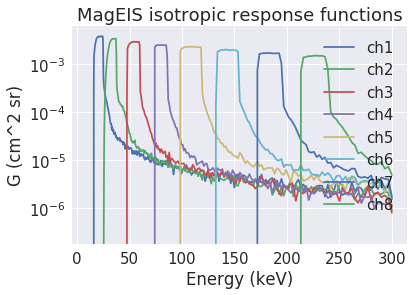

In [93]:
for i in range(*n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS isotropic response functions'); plt.yscale('log');
plt.legend(); #plt.savefig('response.png', dpi=300)

The observed count rates and the official flux from 2016-01-01T00:00:02.823000

In [94]:
c_obs = np.array([275.625, 272.29688, 244.98438, 229.20312 ,
       213.20312, 150.53125, 105.375, 74.515625])*64/11 # Counts/s
FEDU = [1116842.5, 1085755.2, 512022.16, 395646.72, 184992.45,
         52433.65, 21389.389, 11773.138] # Flux from Channels 1-9 (cm^2 s sr keV)^-1

### Model the energy channel-dependent flux 

In [95]:
# Define the energy channel boundaries for the spectra
nE = 5
E_bins = np.linspace(E[0], E[-1], num=nE+1)
istart = [np.where(E >= i)[0][0] for i in E_bins][:-1]
iend = [np.where(E <= i)[0][-1] for i in E_bins][1:]

In [96]:
def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

def lam(JJ):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    """
    lams = (n_ch[1]-n_ch[0])*[0] 
    
    for ch in range(*n_ch):
        # Reset count counter.
        ch_c = 0 
        for i in range(nE):
            # Fold the flux through R
            f = pm.math.dot(JJ[i], R.response(ch)[istart[i]:iend[i]])
            # Calc count contribution to chth energy channel by the ith flux.
            ch_c += pymcTrapz(f, E[istart[i]:iend[i]]) 
        # Save the total counts in chth energy channel from 
        # contributions from all of the fluxes.
        lams[ch-n_ch[0]] = pm.Deterministic('lam{}'.format(ch), ch_c)
    return lams

m = pm.Model()
with m:
    # Prior stocastic variables
    J = pm.Uniform('J', lower=1, upper=1E7, shape=nE)

    lams = lam(J) # Get the count values from the picked J array of values.
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [J_interval__]
100%|██████████| 10500/10500.0 [44:28<00:00,  3.94it/s]


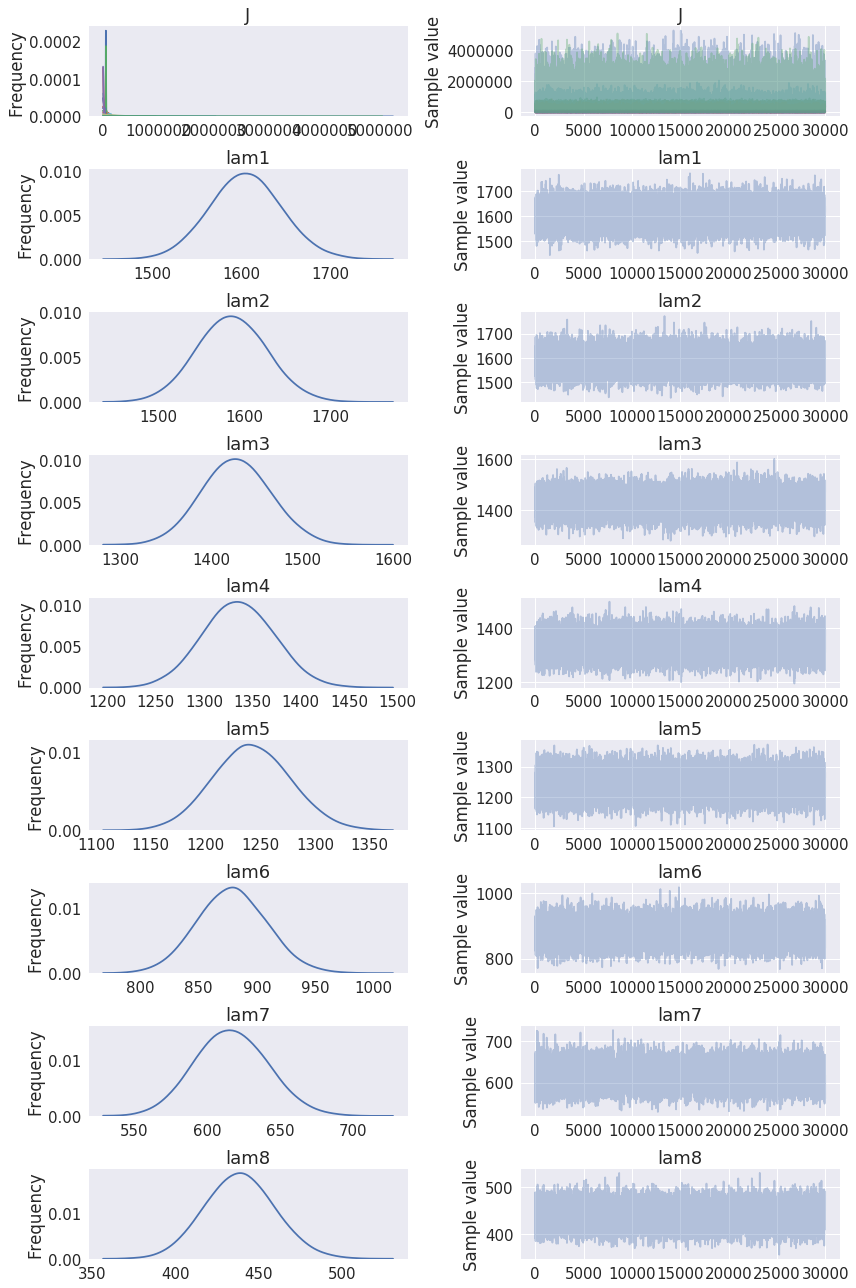

In [97]:
pm.traceplot(trace, combined=True);

In [98]:
pm.summary(trace)

mean             sd     mc_error       hpd_2.5      hpd_97.5  \
J__0    50650.804027    1691.927663     7.311631  47327.448635  5.396472e+04   
J__1    51756.143893    1969.814278    12.507502  48032.239557  5.562195e+04   
J__2    52343.153986   30320.666467   225.829347      8.144783  9.937753e+04   
J__3    35966.695185   20903.055869   158.968614    223.142846  6.879904e+04   
J__4    34591.667711   19955.106939   135.912356    536.726260  6.633258e+04   
J__5    76369.912975   44168.404339   297.447062    135.707210  1.452438e+05   
J__6    22576.501889   13217.671102    81.056079      6.837175  4.326765e+04   
J__7    32950.507700   19021.047270   115.502313    231.004003  6.252689e+04   
J__8    25039.523119   17652.006019    95.763934      2.776101  5.792298e+04   
J__9    13464.253810    9445.862742    53.314074      4.231958  3.119277e+04   
J__10  251470.981116  180214.567369   959.883698     23.141402  5.908322e+05   
J__11   10487.448279    7411.216241    45.422907      2.867709  2.438930e+04   
J__12   12786.263259    8990.305196    48.829154      1.121091  2.962251e+04   
J__13  260607.749459  187811.352055   987.471787      4.143654  6.165275e+05   
J__14    5896.398858    4929.569095    23.771792      1.166561  1.573850e+04   
J__15    5409.627025    4406.776319    22.494260      1.024904  1.424090e+04   
J__16  141243.471217  118092.105919   597.970640      2.632296  3.786944e+05   
J__17  357148.139371  305779.481088  1454.987357     56.090206  9.763755e+05   
J__18  961896.691638  832723.862337  4292.593430     30.336812  2.643563e+06   
J__19  821408.944555  723726.050602  3478.817002    123.185165  2.279094e+06   
lam1     1604.004053      40.099870     0.167270   1525.582157  1.682857e+03   
lam2     1585.093356      40.026473     0.190699   1505.031634  1.661954e+03   
lam3     1426.756465      37.645894     0.230405   1354.633315  1.501903e+03   
lam4     1335.126327      36.862592     0.195178   1264.227400  1.408613e+03   
lam5     1241.942823      35.296576     0.193368   1175.418029  1.313502e+03   
lam6      878.072573      29.701170     0.157440    820.312758  9.370066e+02   
lam7      616.329979      24.837373     0.144845    569.382887  6.660976e+02   
lam8      438.310545      20.837374     0.119727    397.340115  4.787654e+02   

              n_eff      Rhat  
J__0   40553.638325  0.999964  
J__1   25434.027525  1.000000  
J__2   19237.405813  1.000013  
J__3   19107.136762  1.000028  
J__4   23297.967494  0.999951  
J__5   23357.248109  0.999953  
J__6   26129.635169  0.999971  
J__7   26150.895606  0.999966  
J__8   35247.149174  0.999983  
J__9   34015.525929  0.999990  
J__10  32377.963788  0.999962  
J__11  29719.580859  1.000108  
J__12  27332.123545  0.999971  
J__13  30546.072197  1.000007  
J__14  37582.695640  0.999984  
J__15  34539.938995  0.999959  
J__16  39125.999417  0.999955  
J__17  41858.770136  0.999951  
J__18  38578.823718  1.000014  
J__19  34374.354367  0.999953  
lam1   49648.676355  0.999964  
lam2   44862.473968  0.999987  
lam3   30571.844852  1.000101  
lam4   29677.723658  0.999965  
lam5   29534.902040  0.999968  
lam6   29819.468054  0.999975  
lam7   29556.067972  1.000003  
lam8   29801.478650  1.000096

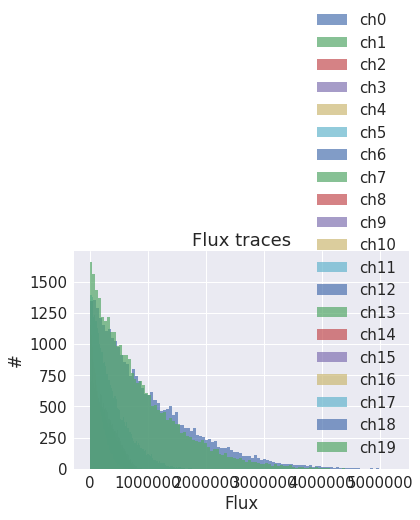

In [99]:
for ch in range(nE):
    plt.hist(trace['J'][:, ch], alpha=0.7, bins=100, label='ch{}'.format(ch))
plt.legend(); plt.title('Flux traces'); plt.ylabel('#'); plt.xlabel('Flux');

Now use the traces to calculate the modeled counts and uncertainties, as well as the flux means and stds.

In [100]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(*n_ch)]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(*n_ch)]

j_mean = np.mean(trace['J'], axis=0)
j_std = np.std(trace['J'], axis=0)

c_Err = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(*n_ch)])

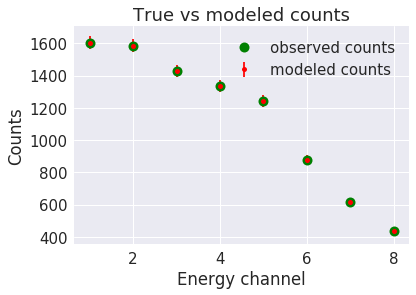

In [101]:
plt.plot(np.arange(*n_ch), c_obs, 'go', label='observed counts', ms=10);
plt.errorbar(np.arange(*n_ch), c_mean, fmt='ro', yerr=c_std, label='modeled counts', ms=5);
plt.legend(); plt.title('True vs modeled counts'); plt.xlabel('Energy channel');
plt.ylabel('Counts');

In [102]:
FEDU_energy = [ 15.,  20.,  33.,  54.,  80., 108., 143., 184., 226.]

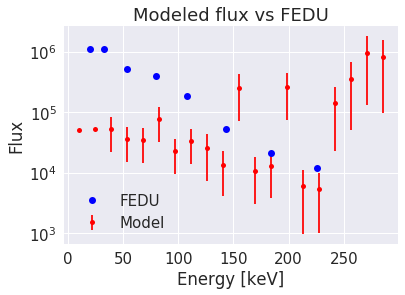

In [103]:
plt.errorbar(E_bins[:-1], j_mean, 
             fmt='ro', yerr=j_std, label='Model', ms=5);
#plt.plot(np.arange(*n_ch), official_flux, 'bo', label='Official')
plt.plot(FEDU_energy[1:], np.array(FEDU), 'bo', label='FEDU')
plt.title('Modeled flux vs FEDU'); plt.xlabel('Energy [keV]'); plt.ylabel('Flux');
plt.yscale('log'); plt.legend(); #plt.savefig('flux_compare.png', dpi=300)